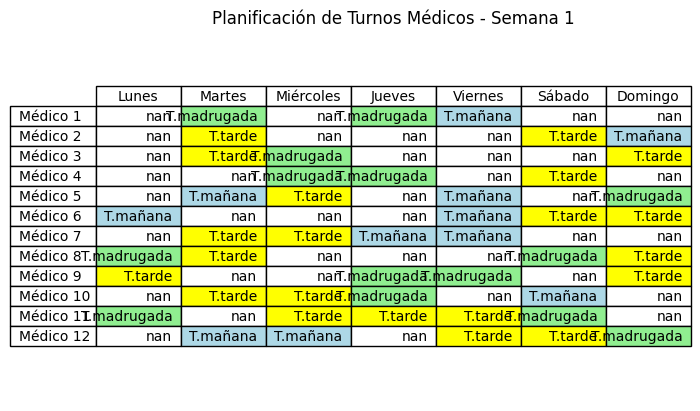

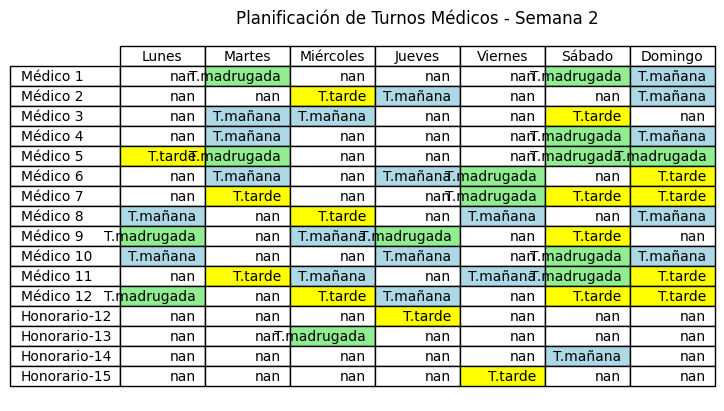

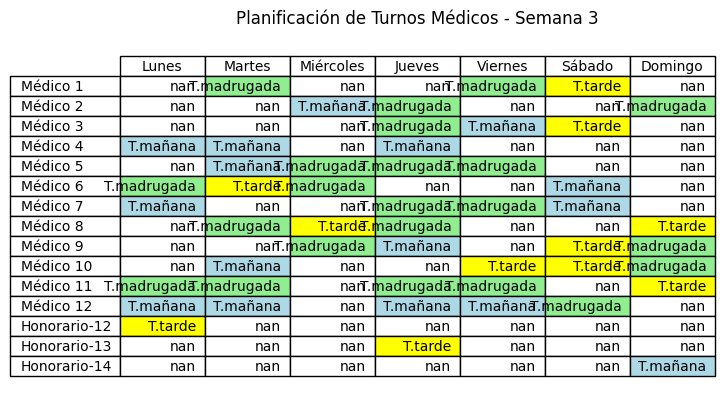

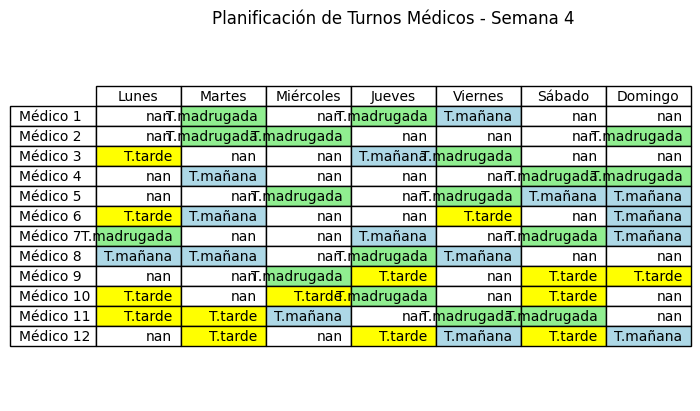

In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Definir los horarios de los turnos y sus colores correspondientes
horarios_turnos = {
    'T.mañana': {'Inicio': '08:00', 'Fin': '17:00', 'Color': 'lightblue'},
    'T.tarde': {'Inicio': '17:00', 'Fin': '00:00', 'Color': 'yellow'},
    'T.madrugada': {'Inicio': '00:00', 'Fin': '08:00', 'Color': 'lightgreen'}
}

# Definir función para asignar turnos a médicos
def asignar_turnos_medicos(num_medicos, num_semanas):
    horarios = ['T.mañana', 'T.tarde', 'T.madrugada']
    dias_semana = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
    semanas = ['Semana 1', 'Semana 2', 'Semana 3', 'Semana 4']

    # Crear DataFrame para almacenar la planificación
    planificacion = {semana: pd.DataFrame(index=range(num_medicos), columns=dias_semana) for semana in semanas}

    # Asignar restricciones de turnos
    restricciones = [3] * 4 + [4] * 6 + [5] * 2  # 3 turnos para 4 médicos, 4 turnos para 6 médicos, 5 turnos para 2 médicos

    # Contadores para las horas trabajadas y médicos honorarios
    horas_trabajadas = {medico: 0 for medico in range(num_medicos)}
    medicos_honorarios = 0

    for semana in semanas:
        turnos_asignados = {medico: 0 for medico in range(num_medicos)}

        # Asignación inicial de turnos
        for medico in range(num_medicos):
            turnos_restantes = restricciones[medico]
            while turnos_restantes > 0:
                np.random.shuffle(dias_semana)
                for dia in dias_semana:
                    if turnos_restantes <= 0:
                        break
                    np.random.shuffle(horarios)
                    for horario in horarios:
                        if pd.isna(planificacion[semana].loc[medico, dia]):
                            planificacion[semana].loc[medico, dia] = horario
                            turnos_asignados[medico] += 1
                            turnos_restantes -= 1
                            if turnos_restantes <= 0:
                                break

        # Verificación y ajuste para asegurar que todos los turnos están cubiertos al menos una vez
        for dia in dias_semana:
            for horario in horarios:
                if planificacion[semana][dia].isin([horario]).sum() < 1:
                    medicos_disponibles = [medico for medico in range(num_medicos) if turnos_asignados[medico] < restricciones[medico]]
                    if medicos_disponibles:
                        np.random.shuffle(medicos_disponibles)
                        for medico in medicos_disponibles:
                            if pd.isna(planificacion[semana].loc[medico, dia]):
                                planificacion[semana].loc[medico, dia] = horario
                                turnos_asignados[medico] += 1
                                break
                    else:
                        # Asignar un médico honorario
                        planificacion[semana].loc[f'Honorario-{len(planificacion[semana])}', dia] = horario
                        medicos_honorarios += 1

        # Contar las horas trabajadas por cada médico
        for medico in range(num_medicos):
            for dia in dias_semana:
                for horario in horarios:
                    if planificacion[semana].loc[medico, dia] == horario:
                        horas_trabajadas[medico] += 8 if horario != 'T.tarde' else 7  # Se cuentan 8 horas para los turnos de mañana y madrugada, 7 para los de tarde

    return planificacion, horas_trabajadas, medicos_honorarios

# Función para generar gráfico de tabla con nombres de médicos por semana
def graficar_planificacion_semanal(planificacion_semanal, semana):
    fig, ax = plt.subplots()
    ax.set_title(f'Planificación de Turnos Médicos - {semana}')
    ax.axis('off')

    # Crear tabla con colores según el tipo de turno
    tabla = ax.table(cellText=planificacion_semanal.values,
                     cellColours=[[horarios_turnos[horario]['Color'] if horario in horarios_turnos else 'white' for horario in row] for row in planificacion_semanal.values],
                     colLabels=planificacion_semanal.columns,
                     rowLabels=[f'Médico {i+1}' if isinstance(i, int) else i for i in planificacion_semanal.index],
                     loc='center')
    tabla.auto_set_font_size(False)
    tabla.set_fontsize(10)
    tabla.scale(1.2, 1.2)
    plt.show()

# Generar planificación de turnos para 12 médicos durante 4 semanas
planificacion_semanal, horas_trabajadas, medicos_honorarios = asignar_turnos_medicos(12, 4)

# Mostrar la planificación por semana
for semana, planificacion in planificacion_semanal.items():
    graficar_planificacion_semanal(planificacion, semana)


In [217]:
# Mostrar las horas trabajadas por cada médico y el número de médicos honorarios
print("Horas trabajadas por médico:")
for medico, horas in horas_trabajadas.items():
    print(f"Médico {medico + 1}: {horas} horas")

print(f"\nNúmero de médicos honorarios: {medicos_honorarios}")

# Calcular las horas trabajadas por los médicos honorarios
horas_honorarios = 0
for semana, planificacion in planificacion_semanal.items():
    for medico in planificacion.index:
        if 'Honorario' in str(medico):
            horas_honorarios += planificacion.loc[medico].isin(['T.mañana', 'T.tarde', 'T.madrugada']).sum() * 8  # 8 horas por turno

print(f"Total de horas trabajadas por médicos honorarios: {horas_honorarios}")


Horas trabajadas por médico:
Médico 1: 95 horas
Médico 2: 93 horas
Médico 3: 91 horas
Médico 4: 95 horas
Médico 5: 126 horas
Médico 6: 122 horas
Médico 7: 123 horas
Médico 8: 123 horas
Médico 9: 121 horas
Médico 10: 121 horas
Médico 11: 152 horas
Médico 12: 152 horas

Número de médicos honorarios: 7
Total de horas trabajadas por médicos honorarios: 56


In [213]:
def calcular_costo(planificacion_semanal, horas_trabajadas, medicos_honorarios):
    costo_por_hora_medico = 21986
    costo_por_hora_honorario = 40000
    horas_por_dia = 24

    costo_diario = 0
    costo_semanal = 0
    costo_mensual = 0

    # Calcular costo diario, semanal y mensual
    for semana, planificacion in planificacion_semanal.items():
        for dia in planificacion.columns:
            for hora in planificacion[dia]:
                if hora == 'T.mañana' or hora == 'T.tarde' or hora == 'T.madrugada':
                    costo_diario += (horas_por_dia - planificacion[dia].isna().sum()) * costo_por_hora_medico
                elif hora == 'Honorario':
                    costo_diario += (horas_por_dia - planificacion[dia].isna().sum()) * costo_por_hora_honorario

        costo_semanal += costo_diario
        costo_diario = 0

    costo_mensual = costo_semanal * 4

    return costo_diario, costo_semanal, costo_mensual

# Calcular el costo
costo_diario, costo_semanal, costo_mensual = calcular_costo(planificacion_semanal, horas_trabajadas, medicos_honorarios)

# Imprimir resultados
print(f"Costo diario aproximado: ${costo_semanal//7}")
print(f"Costo aproximado semanal: ${costo_semanal}")
print(f"Costo aproximado mensual: ${costo_mensual}")

Costo diario aproximado: $10383673
Costo aproximado semanal: $72685716
Costo aproximado mensual: $290742864
